In [1]:
import rasterio as rio
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import dask as da
import h5py as h5
import geopandas as gpd
import pandas as pd
from spectral.io import envi

# enable fiona KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# basemap
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)

point CRS: {'init': 'epsg:32613'}


In [3]:
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*
data_dirs_SWIR, data_dirs_VNIR

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_april09 = [f[:-4] for f in radiance_files_april09]
radiance_files_april09
# radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

# reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
# reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


['../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S1',
 '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S2',
 '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S3',
 '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S4',
 '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S5']

In [4]:
## try to open one of the data files with xarray
data_file = radiance_files_april09[0]
xarr = xr.open_dataset(data_file)



OSError: [Errno -51] NetCDF: Unknown file format: b'D:\\projects\\headwall_neon\\headwall_data\\VNIR\\TableMtn_Flight1_processed\\TM_F1_S1'

In [5]:
## metadata
with rio.open(data_file) as src:
    prof = src.profile
    meta = src.meta
    arr = src.read()
    

In [6]:
arr.shape, meta, prof

((270, 3194, 872),
 {'driver': 'ENVI',
  'dtype': 'float32',
  'nodata': None,
  'width': 872,
  'height': 3194,
  'count': 270,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(8.212976168103843e-07, -0.0, -105.2453348101169,
         -0.0, -6.304198372531518e-07, 40.13155833151619)},
 {'driver': 'ENVI', 'dtype': 'float32', 'nodata': None, 'width': 872, 'height': 3194, 'count': 270, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.212976168103843e-07, -0.0, -105.2453348101169,
        -0.0, -6.304198372531518e-07, 40.13155833151619), 'tiled': False, 'interleave': 'band'})

In [7]:
envi_meta = envi.open(data_file + '.hdr').metadata
wavelength = [float(l) for l in envi_meta['wavelength']]
    

In [8]:
aff = meta['transform']
pix_size_x = aff.a
ul_x = aff.c
pix_size_y = aff.e
ul_y = aff.f

pix_size_x, ul_x, pix_size_y, ul_y

(8.212976168103843e-07,
 -105.2453348101169,
 -6.304198372531518e-07,
 40.13155833151619)

In [ ]:
arr = np.rollaxis(arr, 0, 3)

In [19]:
x = np.arange(ul_x, ul_x + pix_size_x*arr.shape[1], pix_size_x)
y = np.arange(ul_y, ul_y + pix_size_y* arr.shape[0], pix_size_y)

In [20]:
xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
xr_cube_ma = xr_cube.where(xr_cube != -9999)
xr_cube_ma.shape

(3194, 872, 270)

In [21]:
xr_cube_ma[200,200,:]

<xarray.DataArray (bands: 270)>
array([0.039952, 0.051278, 0.082988, ..., 0.261632, 0.193548, 0.18777 ],
      dtype=float32)
Coordinates:
    y        float64 40.13
    x        float64 -105.2
  * bands    (bands) float64 399.1 401.3 403.5 405.8 ... 993.6 995.8 998.0 1e+03

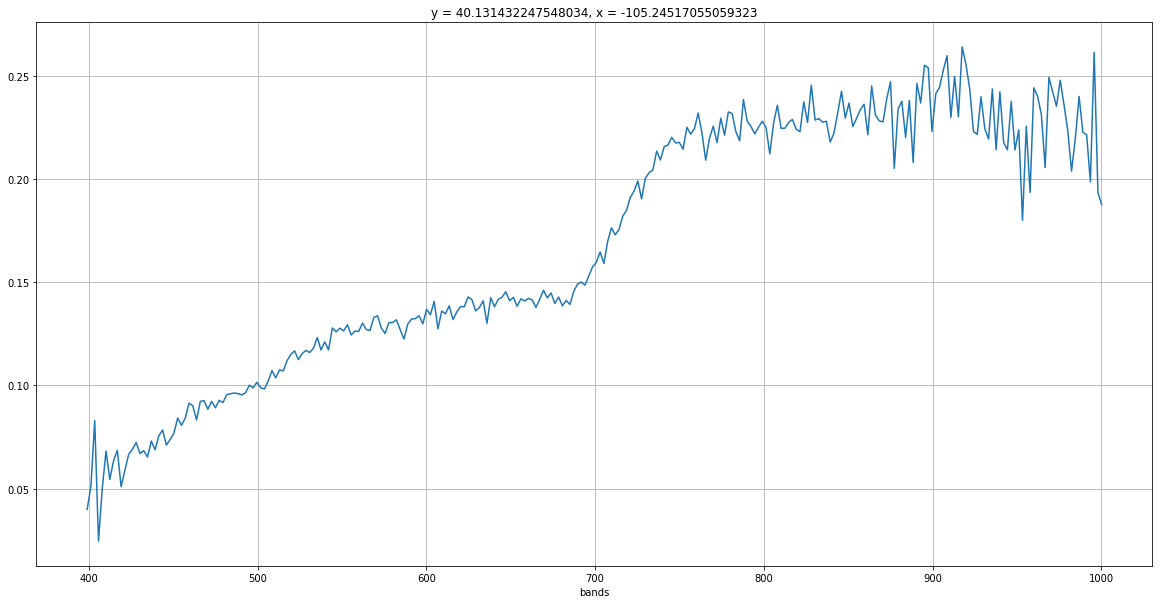

In [22]:
plt.figure(figsize=(20,10))
xr_cube_ma[200,200,:].plot()
plt.grid(True)

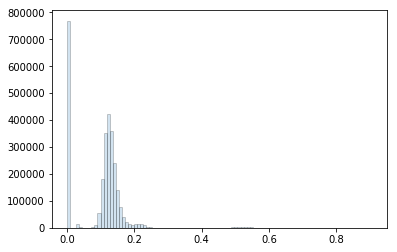

In [23]:
plt.hist(xr_cube_ma[:,:,120].values.ravel(), bins=100, alpha=0.2, edgecolor='k');

In [24]:
np.max(xr_cube_ma).values, y[0] - y[1]

(array(1.0282174, dtype=float32), 6.304198407747208e-07)

# Simulate a spatial extraction

In [25]:
from shapely.geometry import Point

# cross-roads point
pt = Point(-105.24512887001036, 40.1302875511837)
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))
pt_df = pt_df.to_crs(epsg=3857).buffer(10, resolution=1).to_crs(epsg=4326)

# Create a raster mask with the point geometry


In [27]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [28]:
ds = xr.Dataset(coords={'y':y, 'x':x})
# shapes = [(shape, n) for n, shape in enumerate(pt_df.to_crs(epsg=int(crs_epsg)).geometry)]
shapes = [(shape, n) for n, shape in enumerate(pt_df.geometry)]
ds['aoi'] = rasterize(shapes, ds.coords)

In [29]:
ds.aoi.shape, ds.coords['y'][0].values, x.min(), y.min()

((3194, 872), array(40.13155833), -105.2453348101169, 40.129545400964595)

In [30]:
# make the mask == 1
ds['aoi'] = ds.aoi +1

In [31]:
# apply the mask to the data cube
example = ds.aoi*xr_cube_ma 

In [32]:
# get the valid y and x coordinates, then reduce to unique values
val_y, val_x = np.where(ds.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)

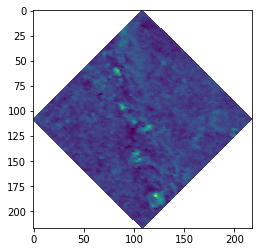

In [33]:
ex2 = example.sel(y=y[u_y], x=x[u_x])
plt.imshow(ex2[:,:,34])
plt.show()

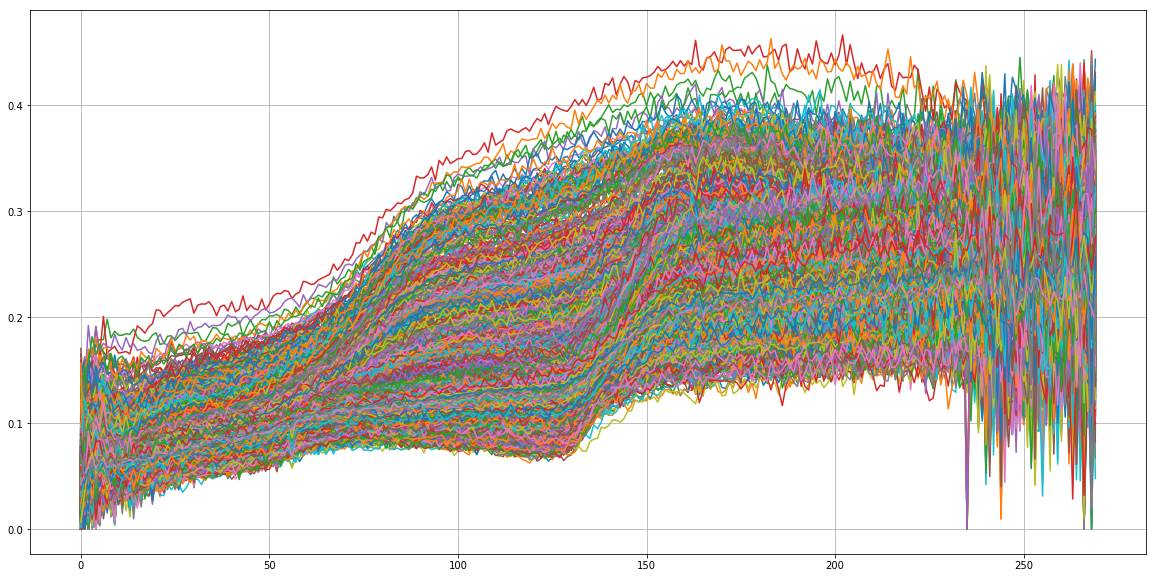

In [34]:
plt.figure(figsize=(20,10))
plt.plot(ex2.values.reshape(-1, ex2.shape[-1]).T);
plt.grid(True)
plt.show()

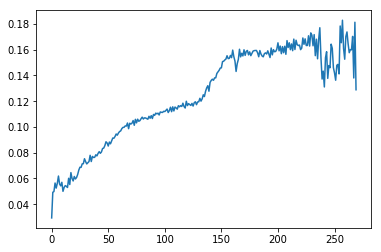

In [42]:
plot_arr = ex2.values.reshape(-1, ex2.shape[-1]).T
plot_arr.shape
plt.plot(plot_arr[:,150*150])

# convert the data array to a dask array with the .chunk method